# PHYS20762 - Project 3 - Monte Carlo Method

Alexander Stansfield <br>
University of Manchester <br>
May 2022

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.constants as const
import pandas as pd

plt.rcParams.update({'font.size': 20})
plt.style.use('default')

# Theory for random number generation

The Monte Carlo method genrally refers to using a random number generator to solve problems. For example, if the random number generator is created such that the probability distribution of the random number generation follows that of the expected behaviour of the system, then the generator can be used to predict the behaviour and, more importantly, characteristics of the system. However, this method can also be used to solve integtals and estimate the value of universal constant, such as $\pi$.

Random numbers are required for this process BLAH EXPLAIN WHY HERE YAY

In this project, we shall use Monte Carlo's method to predict the behaviour of neutrons going through different materials and as such calculate the material's macroscopic characteristics. We shall use numpy's built in np.randon.uniform to create an array of uniformally distributed random numbers, but since the intensity of radiation through a material can be described as:

$$
I(x) = I_0e^{-\frac{x}{\lambda}}
$$

where $I_0$ is the initial raditiation intensity, $x$ is the thickness of the material and $\lambda$ is a constant, where we shall need to create exponential random number generator. The first part of this project will be to create the functions necessary to simulate the neutrons and the second part will have a full simulation for different materials. 

Below is a simple bar plot to picture the behaviour of a uniform distribution. np.random.uniform is used to generate 1000 random numbers between 0 and 1, and the frequency that a number lies in between a given range is plotted. For 1000 numbers the frequency (density) varies an appreciable amount. However, for more points, all the height of the bars will approach the same number, for this plot it will be 1, shown by the red line. This describes a uniform distribution because every number is equally likely to be generated. 

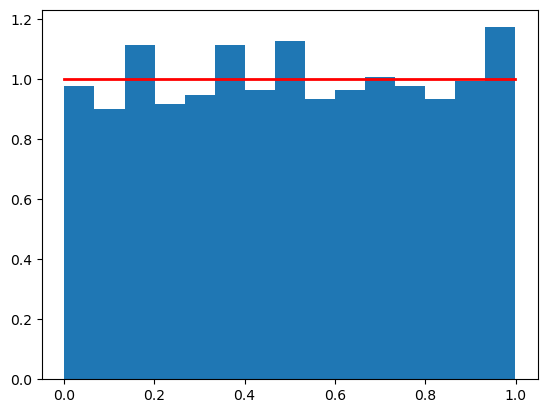

In [106]:
s  = np.random.uniform(0, 1, 1000) #generate 1000 numbers between 0 and 1
count, bins, ignored = plt.hist(s, 15, density = True)
plt.plot(bins, np.ones_like(bins), linewidth = 2, color = 'red')
plt.show()

However, it is naive to say that a random number genaertor is truely random. There is no formula that can be used to generate a random number, only what are called 'pseudo-random' numbers. These are numbers for which when only a few are generated do not appear to follow a pattern. However, when more are generated, a pattern starts to form. This is called the spectral problem. How many numbers need to be generated until a pattern can be seen is dependant on how good the genrator is. For example, below is an example of a Linear Congruential Generator (LCG) which follows the form:

$$
X_{n+1} = (aX_n + c) \text{ mod }m
$$

$X_{n+1}$ is the number to be generated after $X_n$. For large $a$, $c$ and $m$, the numbers appear random. However, as can be see in the left figure below, the spectral problem appears for a large enough number of generations. np.random.uniform() appears to perform much better than that of the LCG.

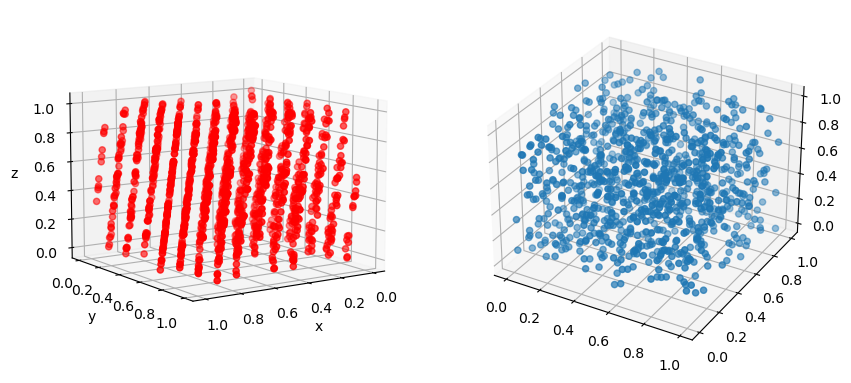

In [107]:
NUMBER_POINTS = 1000

def randssp(p: int,q: int):
    """
    An LCG which generates pseudo random numbers

    Paramaters
    ----------
    p: int --> number of dimensions
    q: int --> number of points

    Returns
    -------
    2D numpy array of floats
    """
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m) #this is the equation shown above to generate numbers
            r[k, l] = x/m
    
    return r

k = randssp(3, 1500)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(k[0, :], k[1, :], k[2, :], color='r')

ax2.scatter(np.random.uniform(0, 1, NUMBER_POINTS), np.random.uniform(0, 1, NUMBER_POINTS), np.random.uniform(0, 1, NUMBER_POINTS))

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.view_init(elev = 10, azim = 56) #the plot for the LCG is rotated in order to clearer see the planes

plt.show()

Now let's create the function required for the rest of the project. When a neutron travels through a material, e.g. water, the distance it travels before colliding with a water molecule (on average) is governed by the mean free path, $\lambda$. This is intrinsic to the material. However, the probability that the neutron travels a certain distance varies exponentially as $P(x) = e^{-\frac{x}{\lambda}}$. If we were to pick a random number which determines the distance the neutron travels, we cannot use a uniform distibution. Thus we will need to manipulate the np.random.uniform() function in order to obtain a distribution which varies exponentially. 

In order to do this, we need to consider how to samnple from an exponential distribution. If we have a probability distribution function (PDF) as:

$$pdf(x) = e^{-x}$$

Then the cumaltive distribution function (CDF) can be found as:

$$cdf(x) = \int_0^xpdf(x) = 1 - e^{-x}$$

The CDF at x tells us how likely a number between 0 and x is to be chosen. Note that the CDF goes between 0 and 1. If we take the inverse of this, we can sample points on the CDF (using a uniform distribution between 0 and 1) and gain a distribution which is exponentially distributed. The inverse of the CDF is:

$$cdf^{-1}(z) = -\ln(1-z)$$

So if $(1-z)$, or $u_i$ is a number picked from a uniform distribution (1- a random number is still a random number) then the output, $x_i$, will be exponentially distributed. This gives us the equation:

$$x_i = -\ln(u_i)$$

Using the probabilty distibution for the distance a neutron tavels for the PDF we instead get:

$$x_i = -\lambda\ln(u_i)$$

This equation will gives us a distribution for neutron travel distances which follows the PDF. 

In [108]:
def random_exponential(mean_free_path: float, quantity: int):
    """
    Function that creates an exponentially distributed, with coefficient lambda = mean_free_path,
    array of random numbers of size 'quanitity' 

    Paramaters
    ----------
    mean_free_path: float
    quantity: int

    Returns
    -------
    1D numpy array of floats of size quantity
    """
    return -mean_free_path*np.log(np.random.uniform(0, 1, quantity))

def exponential_function(data: np.array, coefficient: float):
    """
    Takes in an array (data) and outputs 
    f(x) = 1/lambda * e^{-x/lambda}

    Paramaters
    ----------
    data: 1D array of floats
    coefficient: float

    Returns
    -------
    1D numpy array of floats same size as data
    """
    return 1/coefficient*np.e**(-data/coefficient)

def linear_function(data: np.array, gradient: float, intercept: float):
    """
    Takes in an array (data) and outputs 
    f(x) = m*x + c

    Paramaters
    ----------
    data: 1D array of floats
    gradient: float
    intercept: float

    Returns
    -------
    1D numpy array of floats same size as data
    """
    return gradient*data + intercept

def find_linear_parameters(x: np.array, y: np.array):
    """
    Finds the best values for the gradient and intercept
    of the log graph of the exponential distribution

    np.polyfit is set to only fit a linear function

    Paramaters
    ----------
    x: 1D array of floats
    y: 1D array of floats

    Returns
    -------
    1D array of expected values for gradient and intercept
    2D covaraiance matrix for parameter uncertainties
    """
    try:
        expected, uncertainty = np.polyfit(x, y, 1, full = False, cov=True)
    except RuntimeError:
        print('np.polyfit was not able to find the best parameters')

    return expected, uncertainty

def filter_data(data: np.array):
    """
    A filter which removes all 0 from count in order
    to avoid chances of encountering log(0) = -inf.

    Paramaters
    ----------
    data: 2D array of floats

    Returns
    -------
    2D numpy array of floats
    """
    index = 0
    for line in data:
        if line[1] == 0:
            data = np.delete(data, index, axis = 0)
        else:
            index += 1
    return data

The important function defined above is random_exponential. It is the one which generates an array of randomly generated numbers following an exopnential distribution. All other functions are used to manipulate the data obtained from random_exponential. The figure below on the left shows a bar plot of how many times a number between a given range is generated. As one can see it appears to vary exponentially. In order to fit a line of best fit to the data, we will need to take the logarithm of the count and fit a linear function to the resultant plot, as seen in the figure below on the right. The equation linear function is:

$$
y = -\frac{1}{\lambda}x + \ln(\lambda)
$$

So the gradient of the fitten linear line is the negative inverse of the mean free path. We can use np.polyfit to obtain value for the gradient and intercept, and their respective uncertainties, and thus:

$$
\lambda = -\frac{1}{m} \quad \text{and} \quad \sigma_\lambda = \lambda^2 \sigma_m
$$

The obtained value is then used to plot a fitted exponential function onto the bar plot using the exponential function.
We can compare this value to the coefficient we put into random_exponential, $\lambda_\text{expected}$, and they should be close. For more value, $\lambda$ will approach $\lambda_\text{expected}$ and its respective uncertainty will decrease.

Fitted mean free path is 0.57 \pm 0.040 and mean the free path coefficient put into random number generator is 0.45


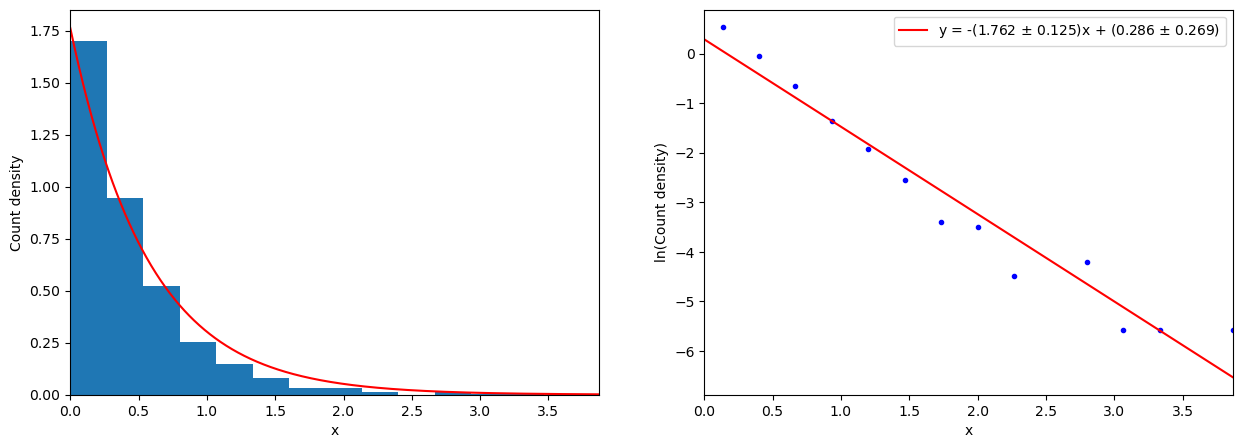

In [109]:
EXPECTED_MEAN_FREE_PATH = 0.45
NUMBER_POINTS = 1000
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

count, bins, ignored = ax1.hist(random_exponential(EXPECTED_MEAN_FREE_PATH, NUMBER_POINTS), 15, density = True)
bin_midpoints = 0.5*(bins[1:] + bins[:-1])
#combining data in order to filter it and avoid log(count = 0) = -inf
data = filter_data(np.vstack((bin_midpoints, count)).T)
p, cov = find_linear_parameters(data[:, 0], np.log(data[:, 1]))
#gradient = -1/lambda and uncertainty_lambda = lamba^2 * sigma_gradient
free_path, free_path_uncertainty, intercept, intercept_uncertainty = -1 / p[0], (1 / p[0])**2 * np.sqrt(cov[0, 0]), p[1], np.sqrt(cov[1, 1])

ax1.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
ax1.set_xlim(0, np.max(bin_midpoints))
ax1.set_ylabel('Count density')
ax1.set_xlabel('x')

ax2.plot(data[:, 0], np.log(data[:, 1]), 'b.')
ax2.plot(np.linspace(0, np.max(data[:, 0]), 10), linear_function(np.linspace(0, np.max(data[:, 0]), 10), -1 / free_path, intercept), \
    color = 'red', label = 'y = -({0:.3f} $\pm$ {1:.3f})x + ({2:.3f} $\pm$ {3:.3f})'\
        .format(1/free_path, free_path_uncertainty / free_path**2, intercept, intercept_uncertainty))
ax2.set_xlim(0, np.max(bin_midpoints))
ax2.set_ylabel('ln(Count density)')
ax2.set_xlabel('x')
ax2.legend()

print('Fitted mean free path is {0:.2f} \pm {1:.3f} and mean the free path coefficient put into random number generator is {2}'.\
    format(free_path, free_path_uncertainty, EXPECTED_MEAN_FREE_PATH))
plt.show()

When a neutron scatters, it is equally likely to go in any direction. Thus we need to find a method of sampling a point on a sphere by some uniform distribution. We can then use that sample as the direction that the neutron will travel. 

A point on a unit sphere can be defined by using two coordinates, 

In the two functions defined below, the polar angle $\theta$ and the azimuthal angle $\phi$. $\theta$ goes between 0 and $\pi$ and describes how north\south the point on the sphere is. $\phi$ goes around anti-clockwise around the equator, so goes between 0 and $2\pi$. However, if we were to uniformally pick 2 random numbers for $\theta$ and $\phi$ and plot the result, figure below on the left, the points are denser around the poles. This is simply a result of the geometry of the sphere.

In order to fix this issue, we need to 'spread out' the points around the poles. To do this, we shall need to create a function which generates fewer numbers close to 0 and $\pi$. A function which does the job is:

$$
x_i = \arccos(1 - 2u_i)
$$

which is used to generate numbers for $\theta$ in the random_unit_sphere function. As one can see by the figure below on the right, the points are much more evenly distributed across the surface than the points obtained from the normal method in poles_gather.


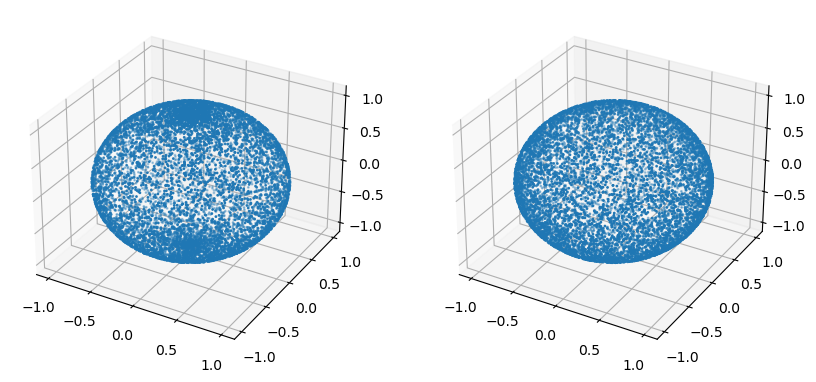

In [110]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

NUMBER_POINTS = 10000

def poles_gather():
    theta = np.random.uniform(0, np.pi, NUMBER_POINTS)
    phi = np.random.uniform(0, 2*np.pi, NUMBER_POINTS)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

def random_unit_sphere():
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, NUMBER_POINTS))
    phi = np.random.uniform(0, 2*np.pi, NUMBER_POINTS)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

ax1.scatter(*poles_gather(), s=1)
ax2.scatter(*random_unit_sphere(), s=1)
plt.show()

To better visualise the distribution of points from the two functions, we shall colour each point bases on density of points in the immedaite vicinity. 

From the two figures produced, the one on the left which uses poles_gather has clear bright points around the two poles. Whereas the figure on the bottom left, produced using random_unit_sphere, is much more evenly distributed.

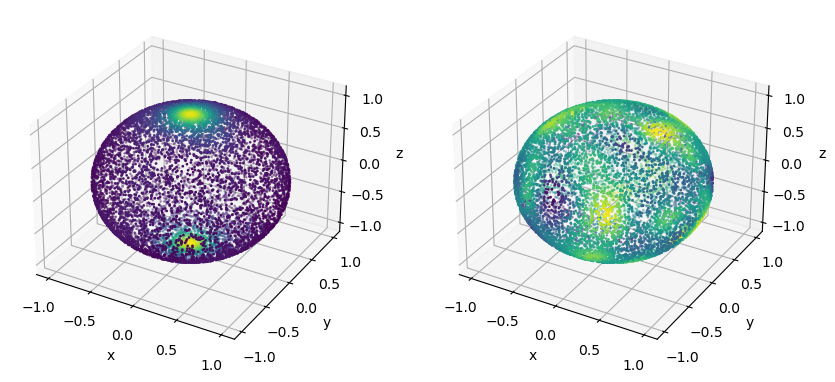

In [111]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def normal_heat_map(axis, x_set, y_set, z_set):
    '''
    Function to generate a heat map from a given 3D datset.
    Uses a gaussian fit to determine the density of the
    values.
    
    Parameters
    ----------
    axis: matplotlib axis object
    x_set : 1D array of floats
    y_set : 1D array of floats
    z_set : 1D array of floats
    
    Returns
    -------
    None
    '''
    density = gaussian_kde([x_set, y_set, z_set])([x_set, y_set, z_set])

    idx = density.argsort()
    x_set = x_set[idx]
    y_set = y_set[idx]
    z_set = z_set[idx]
    density = density[idx]

    axis.scatter(x_set, y_set, z_set, c=density, s=1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')

normal_heat_map(ax1, *poles_gather())
normal_heat_map(ax2, *random_unit_sphere())

We can now use the same maths from random_unit_sphere to create a function which mimics the behaviours of a neutron after it scatters off of a particle. When a neutron is scattered, a random point on a unit sphere is picked and the point of scatter to the random point is used as the new direction of travel. We then generate a random number using the random_exponential function using the mean free path of the material to determine how far the neutron travels before encountering another event.

The figure below on the left are random points picked on a unit sphere times by an array obtained from random_exponential. As one can see by the figure below on the right, the distance each neutron travels is still exponentially distributed.

C:\Users\alexa\AppData\Local\Temp/ipykernel_8828/246300982.py:21: RuntimeWarning: divide by zero encountered in log
  data = filter_data(np.vstack((bin_midpoints, np.log(count))).T)


Fitted mean free path is nan \pm nan and mean free path coefficient put into random number generator is 0.45


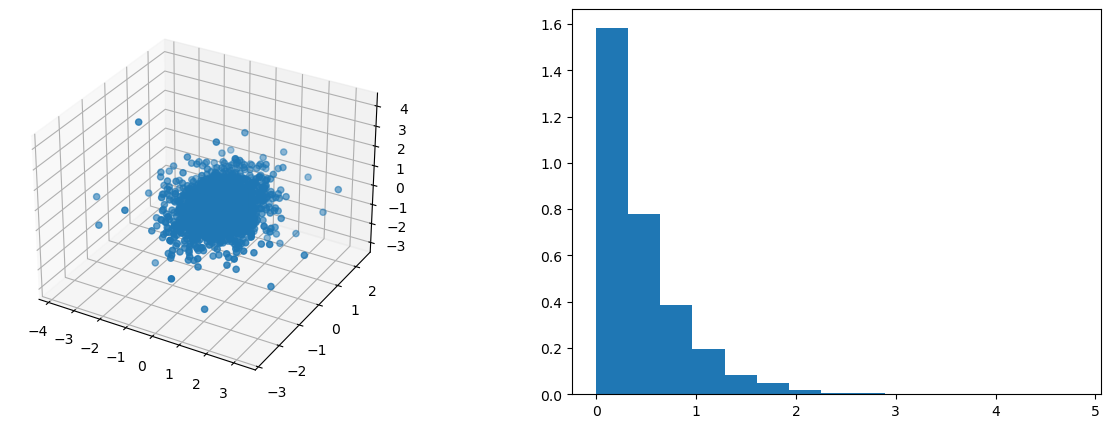

In [112]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

def isotropic_exponential_distribution(mean_free_path, quantity):
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, quantity))
    phi = np.random.uniform(0, 2*np.pi, quantity)
    random_exponential_magnitude = random_exponential(mean_free_path, quantity)
    xdata = np.sin(theta)*np.cos(phi) * random_exponential_magnitude
    ydata = np.sin(theta)*np.sin(phi) * random_exponential_magnitude
    zdata = np.cos(theta) * random_exponential_magnitude

    return xdata, ydata, zdata

data = isotropic_exponential_distribution(EXPECTED_MEAN_FREE_PATH, NUMBER_POINTS)
ax1.scatter(*data)

distance_data = np.sqrt(data[0]**2+data[1]**2+data[2]**2)
count, bins, ignored = ax2.hist(distance_data, 15, density = True)
bin_midpoints = 0.5*(bins[1:]+bins[:-1])
data = filter_data(np.vstack((bin_midpoints, np.log(count))).T)
p, cov= find_linear_parameters(data[:, 0], data[:, 1])
#gradient = -1/lambda and uncertainty_lambda = lamba^2 * sigma_gradient
free_path, free_path_uncertainty = -1 / p[0], (1 / p[0])**2 * np.sqrt(cov[0, 0])
ax2.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
print('Fitted mean free path is {0:.3f} \pm {1:.3f} and mean free path coefficient put into random number generator is {2}'.\
    format(free_path, free_path_uncertainty, EXPECTED_MEAN_FREE_PATH))

plt.show()
    

# Complete Simulation of Absorption

For this simulation, we shall only be considering 2 events which the neutron can encounter: scattering of off an atom/molecule, or being absorbed by an atom/molecule (no neutron-neutron interaction will be considered). Each event can be regarded as an area in space which the neutron intersect for the event to occur. This is called a macroscopic cross section.

Thus, for each material, we need to determine the macroscopic absorption and scattering cross sections, and the resultant total mean free path $\lambda$. The macroscopic cross-section of an event, $\Sigma$, is:

\begin{equation}
\Sigma = n\sigma
\end{equation}

where $n = \frac{\rho N_A}{M}$ and $\sigma$ is the microscopic cross-section of the event. Using the values below for the properties of the materials, we can use the above equation to find the macroscopic cross-section.

\begin{array}{c|ccc}
    & \text{Water} & \text{Lead} & \text{Graphite}\\ \hline
   \text{Absorption}, \sigma_a (barn) & 0.6652 & 0.158 & 0.0045\\
   \text{Scattering}, \sigma_s (barn) & 103.0 & 11.221 & 4.74\\
   \text{Density}, \rho (g/cm^3) & 1.00 & 11.35 & 1.67
\end{array}

where the unit convesions to base units is $1\text{barn} = 10^{-28}m^2$ and $1g/cm^3 = 10^{3}kg/m^3$. Let's store these values into dictionaries so that we can access them easily.

In [113]:
WATER_DICT = {'absorption_sigma': 0.6652e-28, 'scatter_sigma': 103.0e-28, 'density': 1.00e3, 'molar_mass': 18.01528e-3}
LEAD_DICT = {'absorption_sigma': 0.158e-28, 'scatter_sigma': 11.221e-28, 'density': 11.35e3, 'molar_mass': 207.2e-3}
GRAPHITE_DICT = {'absorption_sigma': 0.0045e-28, 'scatter_sigma': 4.74e-28, 'density': 1.67e3, 'molar_mass': 12.011e-3}
MATERIALS_DICT = {'water': WATER_DICT, 'lead': LEAD_DICT, 'graphite': GRAPHITE_DICT}

The total macroscopic cross-section is $\Sigma_T = \Sigma_a + \Sigma_s$ where $\Sigma_a$ is the macroscopic cross-section for absorption events and $\Sigma_s$ is the macroscopic cross-section for scattering events.

The total mean free path, $\lambda_T$, is teh average distance a neutron will travel before encountering one of the events. This can be found as:

\begin{equation}
\lambda = \frac{1}{\Sigma_T} = \frac{1}{\Sigma_a+\Sigma_s}
\end{equation}

In [114]:
def macroscopic_cross_section(density: float, molar_mass: float, cross_section: float):
    """
    Calculates the macroscopic cross section of an event from the
    density, molar mass and microscopic cross section of the event

    Paramaters
    ----------
    density: float
    molar_mass: float
    cross_section: float

    Returns
    -------
    1 float
    """
    n = (density * const.N_A)/molar_mass
    Sigma = n*cross_section
    return Sigma

def attenuation_calculation(Sigma_absorption: float, Sigma_scattering: float):
    """
    Calculates the total mean free path from the macroscopic cross
    sections of absorption and scattering events

    Paramaters
    ----------
    Sigma_absorption: float
    Sigma_scattering: float

    Returns
    -------
    1 float
    """
    mean_free_path = 1/(Sigma_absorption + Sigma_scattering)
    return mean_free_path

Thus the absorption and scattering cross sections, and the resultant total mean free path are found to be (which are then added to the material's dictionary):

In [115]:
for name, material in MATERIALS_DICT.items():
    material['macroscopic_absorption_area'] = macroscopic_cross_section(material['density'], material['molar_mass'], material['absorption_sigma'])
    material['macroscopic_scatter_area'] = macroscopic_cross_section(material['density'], material['molar_mass'], material['scatter_sigma'])
    material['mean_free_path'] = attenuation_calculation(material['macroscopic_absorption_area'], material['macroscopic_scatter_area'])
    print('The macroscopic cross-section of absorption and scattering for {0} is: {1:.3f}, {2:.3f}. The total mean free path is {3:.3f}\
    '.format(name, material['macroscopic_absorption_area'], material['macroscopic_scatter_area'], material['mean_free_path']))

The macroscopic cross-section of absorption and scattering for water is: 2.224, 344.308. The total mean free path is 0.003    
The macroscopic cross-section of absorption and scattering for lead is: 0.521, 37.016. The total mean free path is 0.027    
The macroscopic cross-section of absorption and scattering for graphite is: 0.038, 39.689. The total mean free path is 0.025    


For each neutron travelling through the material, we will need to simulate it travelling a distance based off of the exponential probaility, using isotropic_exponential_distribution defied above. After each step, we then generate a random number between 0 and 1. If the random number is less than probaility of absorption, $p_a = \frac{\Sigma_a}{\Sigma_T}$, then the neutron is aborbed, otherwise it is scattered.

Each neutron starts from one surface of the slab (take as x = 0), and then performs a random walk where each step is drawn from the distribution $e^{-\frac{x}{\lambda_T}}$, as above. Note that for the very first step, the neutron will only be travelling in the x-direction so random_exponential is used instead. After each step, we will need to check whether the neutron is absorbed in the slab, has escaped from the slab (x < 0 or x > T), or continues onto a following step.

Below we have defined a neutron class which stores the its position and state. If the neutron is backscattered (x < 0), transmitted (x > T) or absorbed, the corressponding event is counted and the class instance is deleted from the class array.

It is important to note that this method, i.e. using  object oriented programming, is very slow and we shall define a faster function below. However, the benefit of using classes is that each neutron is very easy to keep track of and manipulate, as well as allowing easy modifications if we so choose in the future. 

In [116]:
NUMBER_NEUTRONS = 100
ITERATIONS= 10
#stores the final state of each neutron
DEAD_PARTICLES = []

class neutron():
    """
    Neutron class which keeps track off each neutron instance created
    as well as their state

    Attributes
    ----------
    sigma_a: float
    sigma_s: float
    mean_free_path: float
    thickness: float

    Methods
    -------
    timestep:
        Checks whether the neutron is absorbed, backscattered
        or tansmitted. If not, the position of the neutron is moved
        dependent on isotropic_exponential_distribution()

        Paramaters
        ----------
        None

        Returns
        -------
        None
    """
    def __init__(self, sigma_a: float, sigma_s: float, mean_free_path: float, thickness: float):
        self.is_absorbed = False
        self.is_backscattered = False
        self.is_transmitted = False
        self.sigma_a = sigma_a
        self.sigma_s = sigma_s
        self.mean_free_path = mean_free_path
        self.thickness = thickness
        #the initial position of the neutron is already moved within (only in x-direction)
        self.x_position = random_exponential(mean_free_path, 1)
        self.x_history = np.array([self.x_position])
        
    def timestep(self):
        if np.random.uniform(0, 1, 1) < (self.sigma_a/(self.sigma_a+self.sigma_s)):
            self.is_absorbed = True
        else:
            self.x_position += isotropic_exponential_distribution(self.mean_free_path, 1)[0]
            self.x_history = np.append(self.x_history, self.x_position)
            if self.x_position < 0:
                self.is_backscattered = True
            elif self.x_position > self.thickness:
                self.is_transmitted = True

def neutron_simulation_class(material:dict, thickness:float):
    """
    Full neutron simulation function using the neutron class method.

    Simulation is run an ITERATIONS number of times and in each iteration,
    NUMBER_NEUTRONS of neutron instances are created

    Slow but the x_position of each neutron can be easily kept track off
    and allows for easy additions in the future.

    Parameters
    ----------
    material: dict
    thickness: float

    Returns
    -------
    2D array of floats
    """
    particle_behaviour_class = np.zeros((0, 3))
    absorption_cross_section = material['macroscopic_absorption_area']
    scattering_cross_section = material['macroscopic_scatter_area']
    free_path = 1/(absorption_cross_section + scattering_cross_section)

    for _ in range(ITERATIONS):
        #class array storing all neutron instances
        neutrons = [neutron(absorption_cross_section, scattering_cross_section, free_path, thickness) for _ in range(NUMBER_NEUTRONS)]
        number_absorbed = 0
        number_backscattered = 0
        number_transmitted = 0
        while len(neutrons) > 0:
            for index, particle in enumerate(neutrons):
                particle.timestep()
                if particle.is_absorbed == True:
                    number_absorbed += 1
                    DEAD_PARTICLES.append(neutrons.pop(index))
                elif particle.is_backscattered == True:
                    number_backscattered += 1
                    DEAD_PARTICLES.append(neutrons.pop(index))
                elif particle.is_transmitted == True:
                    number_transmitted += 1
                    DEAD_PARTICLES.append(neutrons.pop(index))
        particle_behaviour_class = np.vstack((particle_behaviour_class, np.array([number_absorbed, number_backscattered, number_transmitted])))
    return(particle_behaviour_class)

The functions defined immediately below present the data.

In [117]:
def average_behaviour(particle_behaviour:np.array):
    """
    Calculates the average number of absorbed, backscattered and transmitted
    particles of the ITERATIONS iterations. Each average has a corresponding
    uncertainty which is the standard deviation of the data.

    Parameters
    ----------
    particle_behaviour: 2D array of ints

    Returns
    -------
    2D array of floats
    """
    average_absorbed, average_absorbed_uncertainty = np.mean(particle_behaviour[:, 0]), np.std(particle_behaviour[:, 0])
    average_backscattered, average_backscattered_uncertainty = np.mean(particle_behaviour[:, 1]), np.std(particle_behaviour[:, 1])
    average_transmitted, average_transmitted_uncertainty = np.mean(particle_behaviour[:, 2]), np.std(particle_behaviour[:, 2])
    return np.array([[average_absorbed, average_absorbed_uncertainty],\
         [average_backscattered, average_backscattered_uncertainty],\
              [average_transmitted, average_transmitted_uncertainty]])

def print_average_behaviour(material_name:str, averages: np.array, thickness: float):
    """
    Prints the average number of absorbed, backscatted and trasnmitted particles
    along with uncertainties. The material type, number of neutrons simulated, thickness of
    material and how many simulations were made are also printed.

    Parameters
    ----------
    material_name: str
    averages: 2D array of floats
    thickness: float

    Returns
    -------
    None
    """
    print('For {0} with a thickness of {1}m for {2} neutrons in {3} simulations'\
        ', the behaviour of the neutrons is:'.format(material_name, thickness, NUMBER_NEUTRONS, ITERATIONS))
    print('Average number of absorbed neutrons: {0:.2f} \pm {1:.2f}'.format(averages[0, 0], averages[0, 1]))
    print('Average number of backscattered neutrons: {0:.2f} \pm {1:.2f}'.format(averages[1, 0], averages[1, 1]))
    print('Average number of trasmitted neutrons: {0:.2f} \pm {1:.2f}'.format(averages[2, 0], averages[2, 1]))

def behaviour_barplot(particle_behaviour: np.array):
    """
    Displays a barplot of number of events / number of neutron (i.e. the fraction of events)
    for each iteration

    Parameters
    ----------
    particle_behaviour: 2D array of floats

    Returns
    -------
    None
    """
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    colours = ['red', 'green', 'blue']
    label_names = ['Absorbed', 'Backscattered', 'Transmitted']
    label_locations = np.linspace(0, 2.5, 3)  # the label locations
    width = (1/ITERATIONS) # the width of the bars
    for i in range(0, 3):
        for j in range(ITERATIONS):
            ax.bar(label_locations[i] - width/2 - (ITERATIONS/2 - 1)*width + j*width, particle_behaviour[j, i] / NUMBER_NEUTRONS, width, color = colours[i])

    fig.tight_layout()
    plt.xticks(label_locations, label_names, fontsize='17')
    plt.ylim(0, 1)
    plt.show()

def overall_behaviour(material_name:str, simulation_function, thickness: float):
    """
    Displays a barplot of particle behaviour and prints the average behaviour with uncertainties
    for a specific material thickness using either the class or numpy method

    Parameters
    ----------
    material_name: str
    simulation_function: function
    thickness: float

    Returns
    -------
    None
    """
    behaviour = simulation_function(MATERIALS_DICT[material_name], thickness)
    print_average_behaviour(material_name, average_behaviour(behaviour), thickness)
    behaviour_barplot(behaviour)

For water with a thickness of 0.1m for 100 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 18.60 \pm 4.25
Average number of backscattered neutrons: 80.90 \pm 4.53
Average number of trasmitted neutrons: 0.50 \pm 0.67


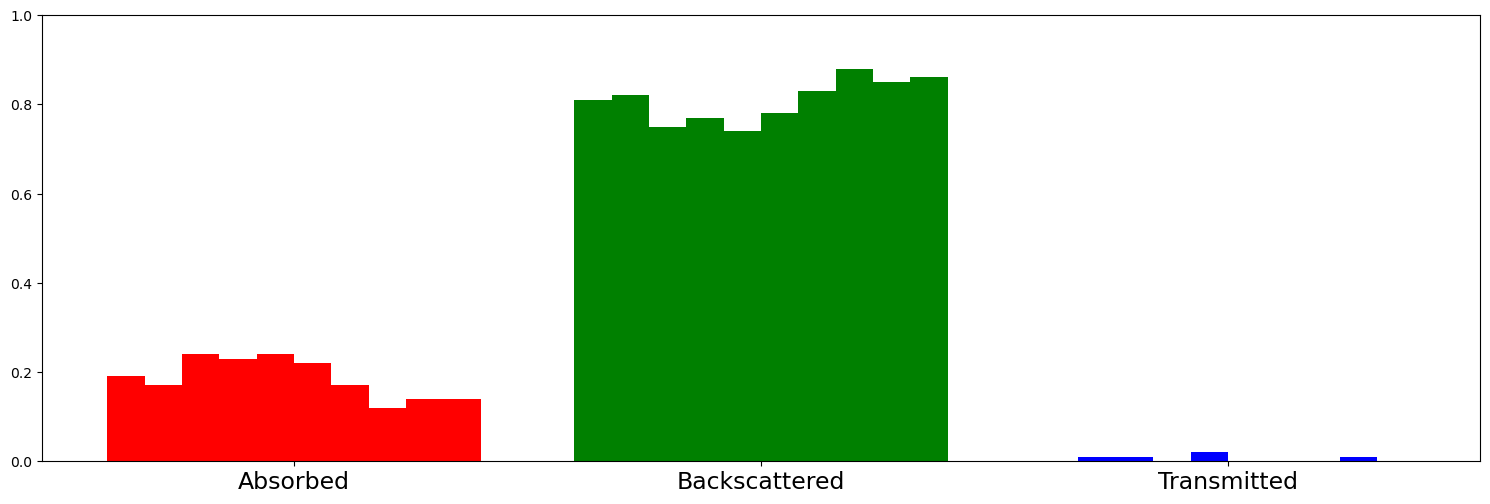

In [118]:
SLAB_THICKNESS = 0.1
overall_behaviour('water', neutron_simulation_class, SLAB_THICKNESS)

So it appears that water is very good as a barrier to neutrons, with a very small portion of neutrons actually making it though. About 80% of neutrons get backscattered and 20% get absorbed, which makes sense since the total free path for water is 0.003m (much smaller than the thickness of the material - 0.5cm) and the macroscopic scattering cross section is so large.

Since the history of the x position of each neutron is stored in the class, we can plot the x position of each neutron as a function of time (each timestep) and see how the system evolves.

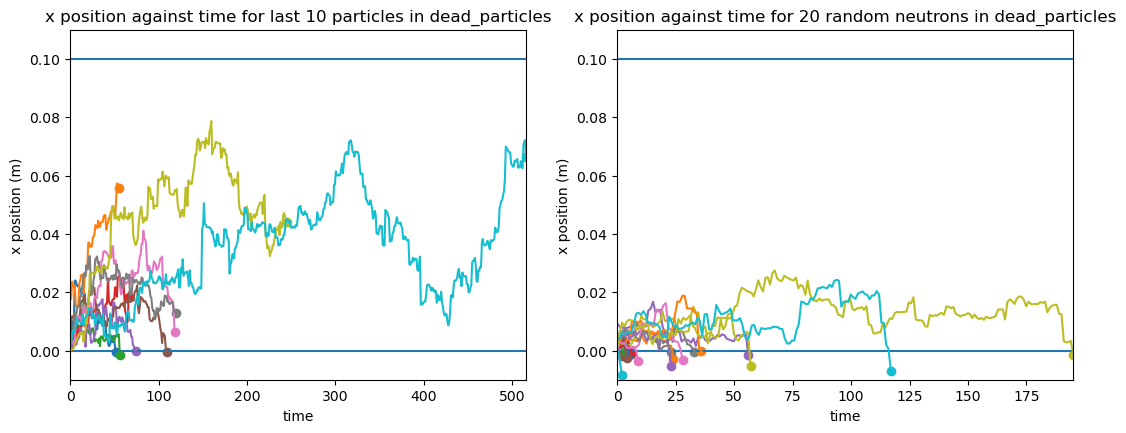

In [119]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)

def particle_path_plot(axis, particles: list):
    """
    Displays a plot of the x position for each neutron over time

    Parameters
    ----------
    axis: matplotlib axis object
    particles: list

    Returns
    -------
    None
    """
    maximum = 0
    for particle in particles:
        if len(particle.x_history) > maximum:
            maximum = len(particle.x_history)
        axis.plot(np.linspace(0, len(particle.x_history), len(particle.x_history)), particle.x_history)
        axis.scatter(len(particle.x_history), particle.x_history[-1])

    axis.hlines(0, 0, maximum)
    axis.hlines(SLAB_THICKNESS, 0, maximum)
    axis.set_ylim(-SLAB_THICKNESS / 10, SLAB_THICKNESS + SLAB_THICKNESS / 10)
    axis.set_xlim(0, maximum)
    axis.set_xlabel('time')
    axis.set_ylabel('x position (m)')

#takes the last ten points in dead particles
particle_path_plot(ax1, DEAD_PARTICLES[-10:])
ax1.set_title('x position against time for last 10 particles in dead_particles')
#takes 10 random neutrons from the dead particles list
particle_path_plot(ax2, np.take(DEAD_PARTICLES, np.random.randint(0, len(DEAD_PARTICLES), 20)))
ax2.set_title('x position against time for 20 random neutrons in dead_particles')
plt.show()

The last 10 neutrons in the dead particles list are the last ones to be deleted from the neutron class array. Thus it appears that few neutrons get backscattered. However, it we take 20 random neutrons, then as expected a large proportion are backscattered in water.

In order to make the simulation faster, we shall instead use numpy.arrays to store the x position of each neutron. This is a lot faster since when changing the x positions we can manipulate each neutron at the same time rather than one at a time which the class method does.

It is possible to make the class method considerably faster by using the python library called multiprocessing which allows to run multiple function parallel to each other (i.e. run multiple neutron.timestep simultaneously) but Jupyter notebook is not built to create multiple function instances.

In [120]:
def neutron_simulation_eff(sample_size:int, material:dict, thickness:float):
    """
    A more efficient version of the previous class method, using numpy instead
    of other function calls.

    'sample_size' number of neutrons is created which travel through 'material'
    of size 'thickness'.

    Parameters
    ----------
    sample_size: int
    material:dict
    thickness:float

    Returns
    -------
    3 ints
    """
    sigma_a = material['macroscopic_absorption_area']
    sigma_s = material['macroscopic_scatter_area']
    mean_free_path = attenuation_calculation(sigma_a, sigma_s)
    probability_absorption = sigma_a / (sigma_a + sigma_s) 
    absorbed = transmitted = backscattered = 0
    
    neutron_array = np.zeros((sample_size, 3))
    neutron_array[:, 0] = random_exponential(mean_free_path, sample_size)

    
    while absorbed + transmitted + backscattered < sample_size:
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        transmitted += len(np.argwhere(neutron_array[:, 0] >= thickness))
        neutron_array = np.delete(neutron_array, np.argwhere(neutron_array[:, 0] >= thickness), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        random_reference = np.random.uniform(0, 1, neutrons_left)

        absorbed += len(np.argwhere(random_reference < probability_absorption))
        neutron_array = np.delete(neutron_array, np.argwhere(random_reference < probability_absorption), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed
        
        backscattered += len(np.argwhere(neutron_array[:, 0] < 0))
        neutron_array = np.delete(neutron_array, np.argwhere(neutron_array[:, 0] < 0), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        temp_x, temp_y, temp_z = isotropic_exponential_distribution(mean_free_path, neutrons_left)
        neutron_array[:, 0] += temp_x
        neutron_array[:, 1] += temp_y
        neutron_array[:, 2] += temp_z

    return absorbed, backscattered, transmitted

def iterative_neutron_simulation_eff(material: dict, thickness:float):
    particle_behaviour_eff = np.zeros((0, 3))
    for _ in range(ITERATIONS):
        particle_behaviour_eff = np.vstack((particle_behaviour_eff, neutron_simulation_eff(NUMBER_NEUTRONS, material, thickness)))
    return particle_behaviour_eff

Now we can create many more neutrons, and as such the averages for each simulation will tend towards a value and the true overall behaviour of each material will become more apparent.

For water with a thickness of 0.1m for 15000 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 3071.80 \pm 56.07
Average number of backscattered neutrons: 11884.30 \pm 60.52
Average number of trasmitted neutrons: 43.90 \pm 6.25


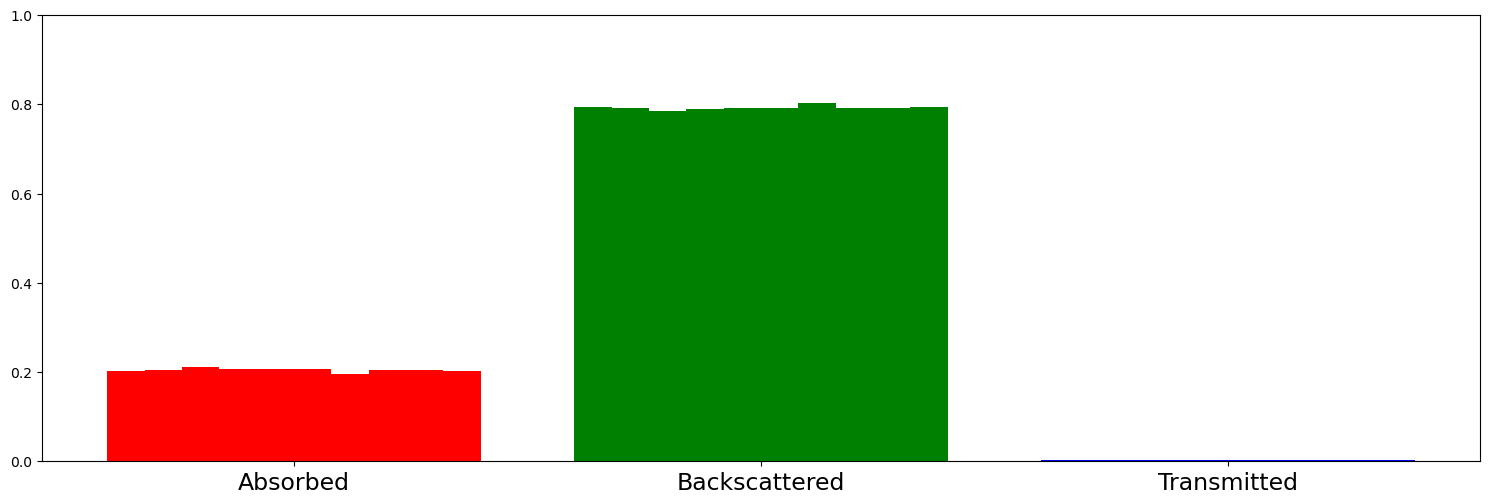

For lead with a thickness of 0.1m for 15000 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 1636.50 \pm 31.86
Average number of backscattered neutrons: 9174.50 \pm 44.44
Average number of trasmitted neutrons: 4189.00 \pm 43.79


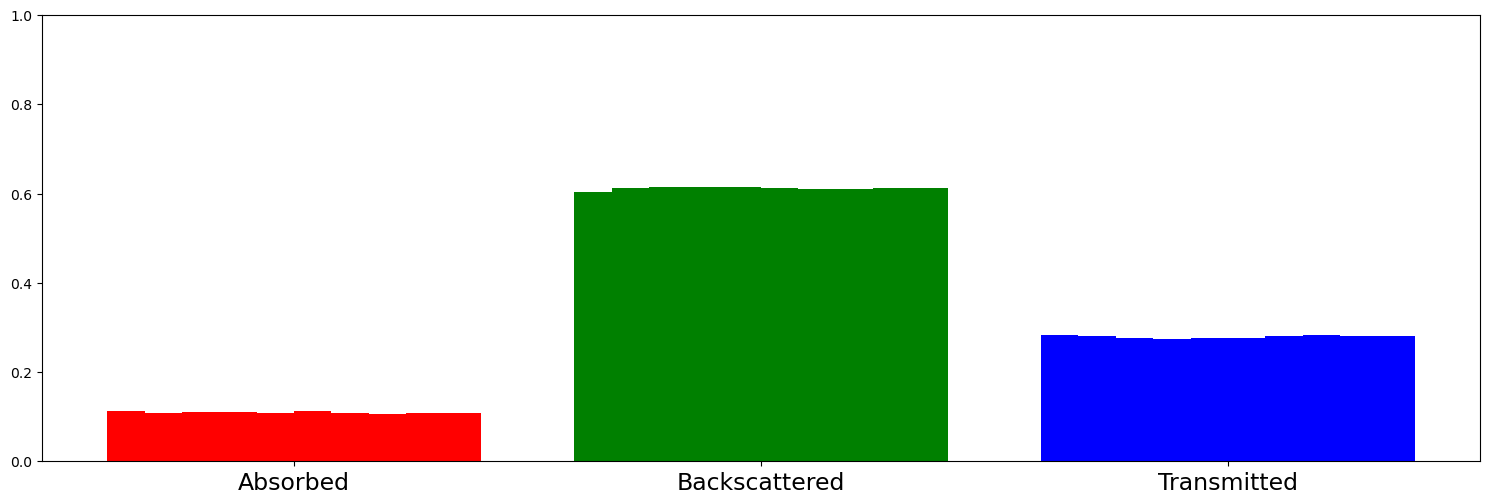

For graphite with a thickness of 0.1m for 15000 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 121.40 \pm 10.50
Average number of backscattered neutrons: 10257.60 \pm 42.07
Average number of trasmitted neutrons: 4621.00 \pm 46.68


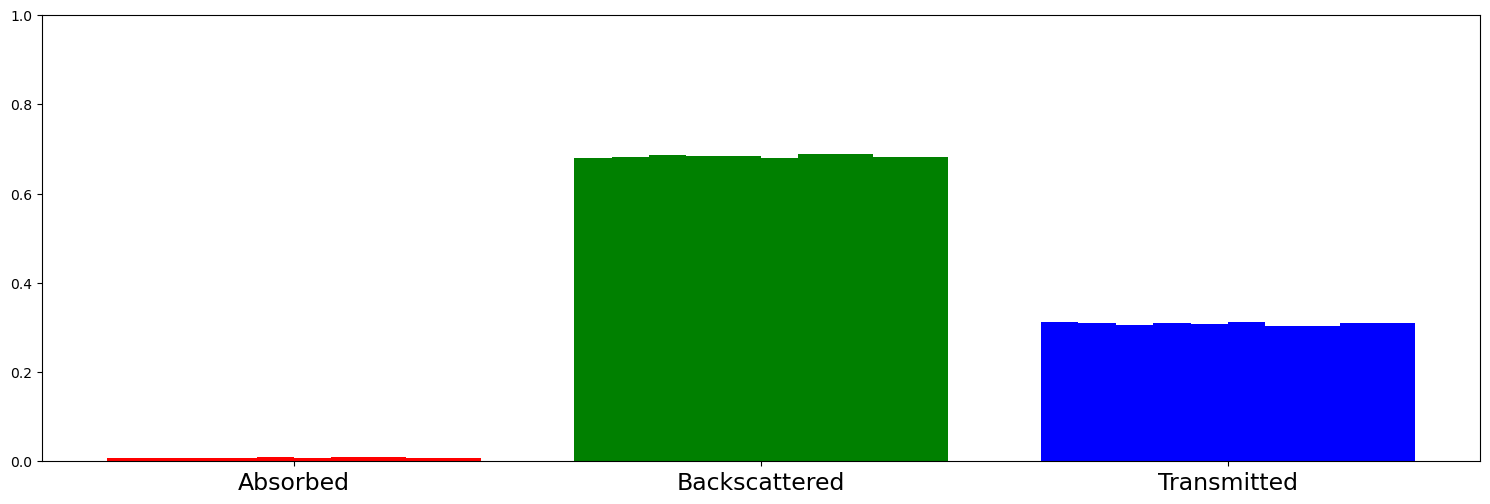

In [121]:
NUMBER_NEUTRONS = 15000
overall_behaviour('water', iterative_neutron_simulation_eff, SLAB_THICKNESS)
overall_behaviour('lead', iterative_neutron_simulation_eff, SLAB_THICKNESS)
overall_behaviour('graphite', iterative_neutron_simulation_eff, SLAB_THICKNESS)

So for water, very few neutrons are able to penetrate through for a thickness of 0.1m. There is then an ~80/20 split between backscattered and absorbed neutrons. 

For graphine and lead, many more neutrons are able to penetrate through, with graphine being marginally the worst. This is expected since the total mean free path for lead and graphene are very similar. 

In lab experiments, the main macrocopic behaviour which is obeserved is the fraction of neutrons which penetrate through a material. This is especially important in siuations such as for a nuclear reactor where a very efficient blocker of radioactive particles is required. How good a material is at stopping particles penetrating through is called its 'attenuation factor', $\mu$. It can be found as:

$$
I(x) = I_0e^{-\mu x}
$$

$\mu$ represents the probability that the neutron is either scattered or absorbed per unit length and $x$ is the thickness of the material. The attenuation is therefore related to the mean free path as $\mu = \frac{1}{\lambda}$. In order to determine the attenuation factor of each material, we need to find the fraction of transmitted neutrons for different thicknessess and fit a curve using the same method as at the start of the project.

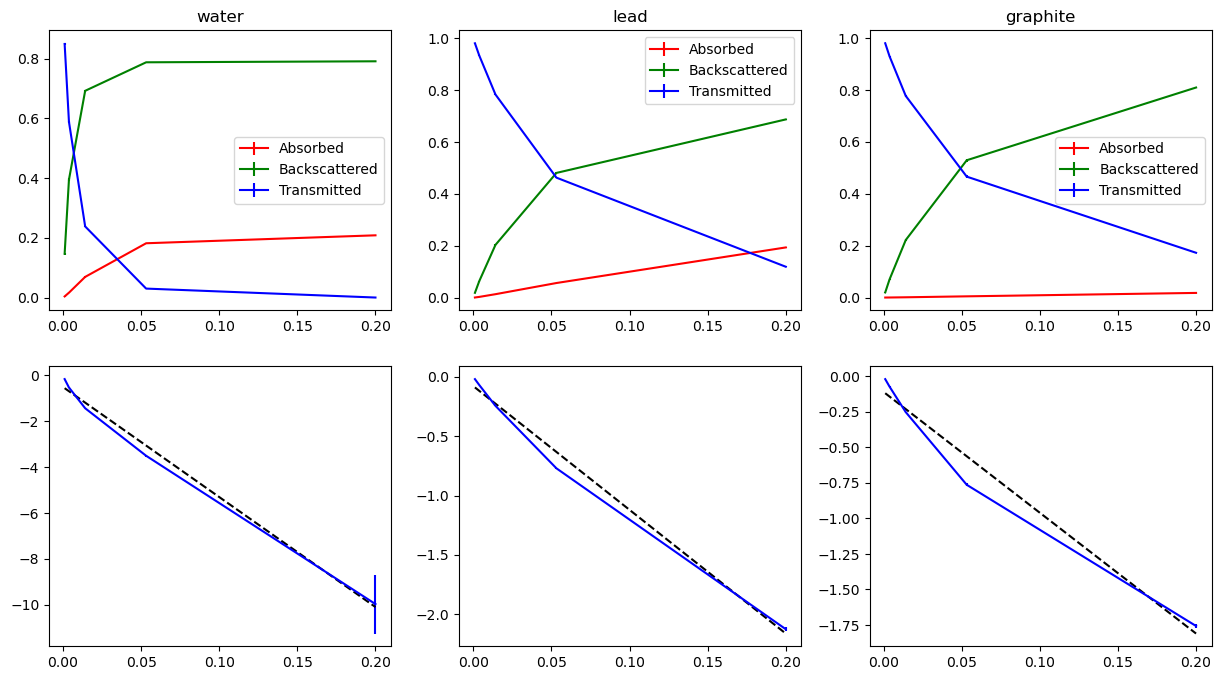

  Material Name Attenuation coefficient (m^{-1}) Mean free path (m)
0         water                     48.0 \pm 2.3  0.0209 \pm 0.0010
1          lead                     10.4 \pm 0.6    0.096 \pm 0.005
2      graphite                      8.5 \pm 0.8    0.118 \pm 0.011


In [122]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
axes = np.array([[ax1, ax2, ax3], [ax4, ax5, ax6]])

def varying_thickness(starting_thickness: float, ending_thickness: float, number_thicknesses: int):
    """
    Function which finds the overall behaviour of the neutrons at different thicknesses
    from starting_thickness to ending thickness (done 'number_thicknesses' times) for
    all materials (itmes) in the MATERIALS_DICT dictionary.

    A plot is then made for the ratio of absorbed/backscattered/transmitted neutrons
    against material thickness and a plot of log(transmitted) against thickness
    along with the fitted linear function.

    Note that zero thickness cannot be used since we have np.geomspace to create the
    thickness array (larger thickness would take longer, so fewer larger thicknesses
    are simulated to reduce run time)

    Parameters
    ----------
    starting_thickness: float
    ending_thickness: float
    number_thicknesses: int

    Returns
    -------
    None
    """
    index = 0
    attenuation_factors = np.zeros((0,2))
    for material_name, material_dict in MATERIALS_DICT.items():
        axes[0][index].set_title(material_name)
        absorbed_behaviour = np.zeros((0, 2))
        backscattered_behaviour = np.zeros((0, 2))
        transmitted_behaviour = np.zeros((0, 2))
        thickness_array = np.geomspace(starting_thickness, ending_thickness, number_thicknesses)
        for material_thickness in thickness_array:
            average_array = average_behaviour(iterative_neutron_simulation_eff(material_dict, material_thickness)) / NUMBER_NEUTRONS
            absorbed_behaviour = np.vstack((absorbed_behaviour, average_array[0, :]))
            backscattered_behaviour = np.vstack((backscattered_behaviour, average_array[1, :]))
            transmitted_behaviour = np.vstack((transmitted_behaviour, average_array[2, :]))
        axes[0][index].errorbar(thickness_array, absorbed_behaviour[:, 0], yerr = absorbed_behaviour[:, 1],\
            color = 'red', label = 'Absorbed')
        axes[0][index].errorbar(thickness_array, backscattered_behaviour[:, 0], yerr = backscattered_behaviour[:, 1],\
            color = 'green', label = 'Backscattered')
        axes[0][index].errorbar(thickness_array, transmitted_behaviour[:, 0], yerr = transmitted_behaviour[:, 1],\
            color = 'blue', label = 'Transmitted')
        axes[0][index].legend()

        xdata = np.linspace(starting_thickness, ending_thickness, 10)
        parameters_linear, uncertainty_linear = find_linear_parameters(thickness_array, np.log(transmitted_behaviour[:, 0]))
        attenuation, attenuation_uncertainty = -parameters_linear[0], np.sqrt(uncertainty_linear[0, 0])
        intercept, intercept_uncertainty = parameters_linear[1], np.sqrt(uncertainty_linear[1, 1])
        axes[1][index].errorbar(thickness_array, np.log(transmitted_behaviour[:, 0]), yerr = (1 / transmitted_behaviour[:, 0]) * transmitted_behaviour[:, 1], color = 'blue', label = 'Transmitted')
        axes[1][index].plot(xdata, linear_function(xdata, -attenuation, intercept), 'k--')

        attenuation_factors = np.vstack((attenuation_factors, np.array([attenuation, attenuation_uncertainty])))
        index += 1
    plt.show()
    return attenuation_factors

attenuation_coefficients = varying_thickness(0.001, 0.2, 5)

data = {'Material Name': MATERIALS_DICT.keys(),
        'Attenuation coefficient (m^{-1})': ['{0:.1f} \pm {1:.1f}'.format(attenuation_coefficients[0, 0], attenuation_coefficients[0, 1]),\
            '{0:.1f} \pm {1:.1f}'.format(attenuation_coefficients[1, 0], attenuation_coefficients[1, 1]),
            '{0:.1f} \pm {1:.1f}'.format(attenuation_coefficients[2, 0], attenuation_coefficients[2, 1])],
        'Mean free path (m)': ['{0:.4f} \pm {1:.4f}'.format(1 / attenuation_coefficients[0, 0], 1 / (attenuation_coefficients[0, 0]**2) * attenuation_coefficients[0, 1]),\
            '{0:.3f} \pm {1:.3f}'.format(1 / attenuation_coefficients[1, 0], 1 / (attenuation_coefficients[1, 0]**2) * attenuation_coefficients[1, 1]),
            '{0:.3f} \pm {1:.3f}'.format(1 / attenuation_coefficients[2, 0], 1 / (attenuation_coefficients[2, 0]**2) * attenuation_coefficients[2, 1])],
}
df = pd.DataFrame(data)
print(df)

These values are incredibly similar to the obtained experimental values.

- For water: $\lambda$ ~0.02m
- For lead: $\lambda$ ~0.09m
- For graphite: $\lambda$ ~0.10-0.13m

and all values found lie within 3 standard deviations. Note that the values can vary considerably, that is jus the nature of using random numbers. But overall, the simulation matches very closely to reality.

## Woodcock method

When a neutron travels through two different materials (with 2 different total mean free paths), the problem becomes more complicated. This is because if the neutron takes a step which crosses the boundary from one material into another, the neutron will behave differently depending on which material it is in. Thus we cannot use the same method of generating a random travel distance using isotropic_exponential distribution for each step, as it would not be correct if the travel crosses the boundary.

We could take a step, see if the neutron crosses the boundary within that step, move the neutron to the boundary and then redo the calculation for the rest of the step using the characteristics of ther other material, but this is complicated and will take a lot of computing power (doing this every time for every neutron). This is where the Woodcock method comes in.

To solve this problem, the Woodock method introduces another possible event the neutron can encounter. This is called a fictitious step. Let's say that the total macroscopic cross section of material 1, $\Sigma_1$ is less then the total macroscopic cross section of material 2, $\Sigma_2$. This means that $\lambda_1 > \lambda_2$ (i.e. the neutron on average travels further in material 1 between events). What we can do is say that when the neutron is in material 1, it can either take a real step (where normal physics applies) or a fictitious step. A fictitious step is one in which the neutron continues to travel in the same direction, as if no event has occured. However, the important factor is that the distance the neutron travels during a fictitious step is determined by $\lambda_2$ rather than $\lambda_1$. What this ensures is that the neutron will behave correctly when crossing from material 1 into material 2. Moreover, since $\lambda_2 < \lambda_1$, it will (on average) travel a shorter distance than during a real step. This introduction of fictitious steps takes care of the complications which arise from the othger method mentioned above. Now let's talk abot how to actually implement it.

First we need to pick which macroscopic cross section is larger. We shall call this $\Sigma_T$. The probability that the neutron takes a real step is:

$$
P_\text{real} = \frac{\Sigma}{\Sigma_T}
$$

where $\Sigma$ is the macroscopic cross section of the material the neutron is in. Note that this probability will equal one when the neutron is in the material with the larger macroscopic cross section. We then generate a uniformally distributed number, $u_i$, and if $u_i < P_\text{real}$, then the neutron wil take a real step and the normal function which we have defined above are applied. However, if $u_i > P_\text{real}$, then the neutron takes a fictitious step.

When a fictitious step is taken, we need to change the position of the neutron according to $\lambda_T = \frac{1}{\Sigma_T}$ in the same direction that the neutron was travelling.

The functions for the real and fictitious step are defined below.

In [123]:
def real_step(particles: np.array, free_path: float, macroscopic_cross_sections: float, absorbed: int, backscattered: int, transmitted: int, max_thickness: float):
    """
    Function which takes in the particles which will take a real step and applies the normal physics of the material,
    dependant on 'free_path' and 'macroscopic_cross_sections'.

    Checks whether neutron has been absorbed, backscattered or transmitted, increments the corresponding
    counter and deletes them from 'particles'.

    If none of the above events have occured, the neutron is scattered according to
    isotropic_exponetial_distribution.

    Returns the current and previous position of neutron (for fictitious step calculation) and
    with absorbed, backscattered, transmitted neutrons deleted. Also returns new absorbed,
    backscattered and transmitted counter

    Parameters
    ----------
    particles: np.array
    free_path: float
    macroscopic_cross_sections: float
    absorbed: int
    backscattered: int
    transmitted: int
    max_thickness: float
    Returns
    -------
    2 2D arrays of floats
    3 ints
    """
    #transmitted criteria
    transmitted += len(np.argwhere(particles[:, 0] > max_thickness))
    particles = np.delete(particles, np.argwhere(particles[:, 0] > max_thickness), axis = 0)
    #backscattered criteria
    backscattered += len(np.argwhere(particles[:, 0] < 0))
    particles = np.delete(particles, np.argwhere(particles[:, 0] < 0), axis = 0)
    #absorption criteria
    u = np.random.uniform(0, 1, len(particles))
    probability_absorption = macroscopic_cross_sections[0] / np.sum(macroscopic_cross_sections)
    absorbed += len(np.argwhere(u < probability_absorption))
    particles = np.delete(particles, np.argwhere(u < probability_absorption), axis = 0)
    previous_particles = particles.copy()
    #if none of the above, the particles is scattered
    particles += np.array(isotropic_exponential_distribution(free_path, len(particles))).T
    return particles, previous_particles, absorbed, backscattered, transmitted

def fictitious_step(current_position: np.array, previous_position: np.array, free_path: float):
    """
    Function which fictitiously steps the neutron through the material
    according to 'free_path' of other material in the same direction as
    'current_position - previous_position'.

    Returns the updated values for previous_position and
    current_position

    Parameters
    ----------
    current_position: 2D array of floats
    previous_position: 2D array of floats
    free_path: float
    Returns
    -------
    2 2D arrays of floats
    """
    difference_vector = np.add(current_position, previous_position*-1)
    magnitude = np.sqrt(np.sum(difference_vector**2, axis = 1))
    normalised_direction = difference_vector / magnitude[:, None]
    step = normalised_direction * random_exponential(free_path, len(normalised_direction))[:, None]
    previous_position = current_position.copy()
    current_position += step
    return current_position, previous_position

Finally we define the Woodock function itself. Note that I have not implemented $\Sigma_1 > \Sigma_2$.

All it does is while there are still neutrons that have not been absorbed, backscattered or transmitted, a random number is compared to the probabilty of taking a real step. If $u_i$ > $P_\text{real}$ and the neutron is in the first material, then the ficitious_step function is called. If $u_i$ < $P_\text{real}$ and the neutron is in material 1, then real_step is called. Otherwise, the neutron takes a regular step in material 2.

For water with a thickness of 0.1m for 15000 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 3011.90 \pm 64.37
Average number of backscattered neutrons: 11939.00 \pm 63.61
Average number of trasmitted neutrons: 49.10 \pm 6.43


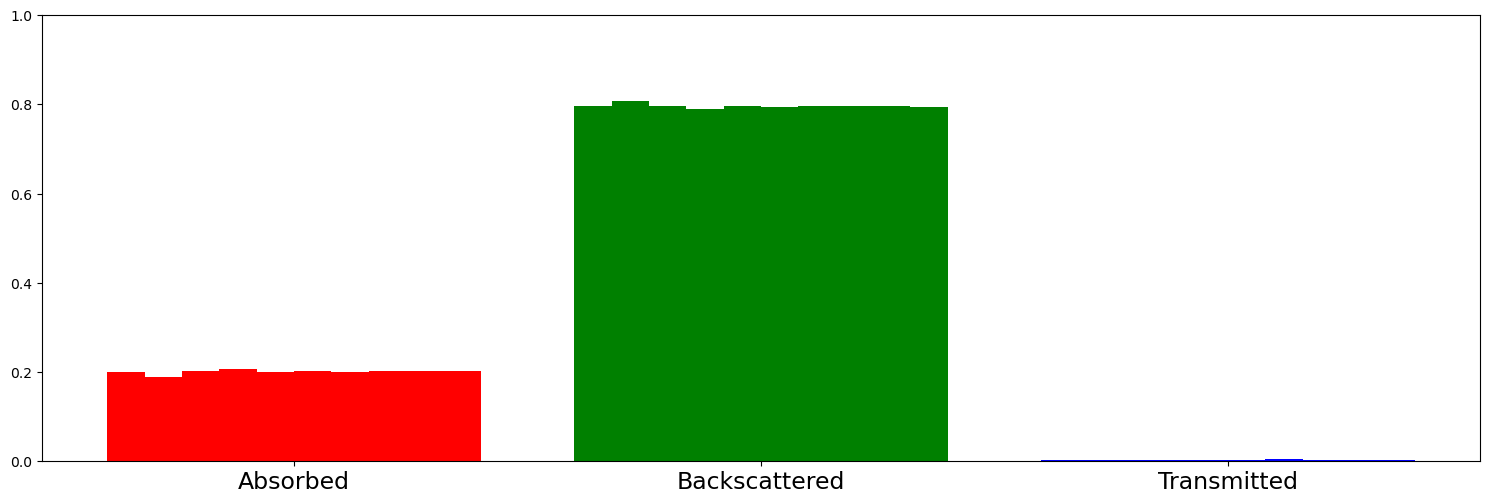

For water with a thickness of 0.1m for 15000 neutrons in 10 simulations, the behaviour of the neutrons is:
Average number of absorbed neutrons: 4279.00 \pm 56.85
Average number of backscattered neutrons: 8481.00 \pm 73.85
Average number of trasmitted neutrons: 2240.00 \pm 41.01


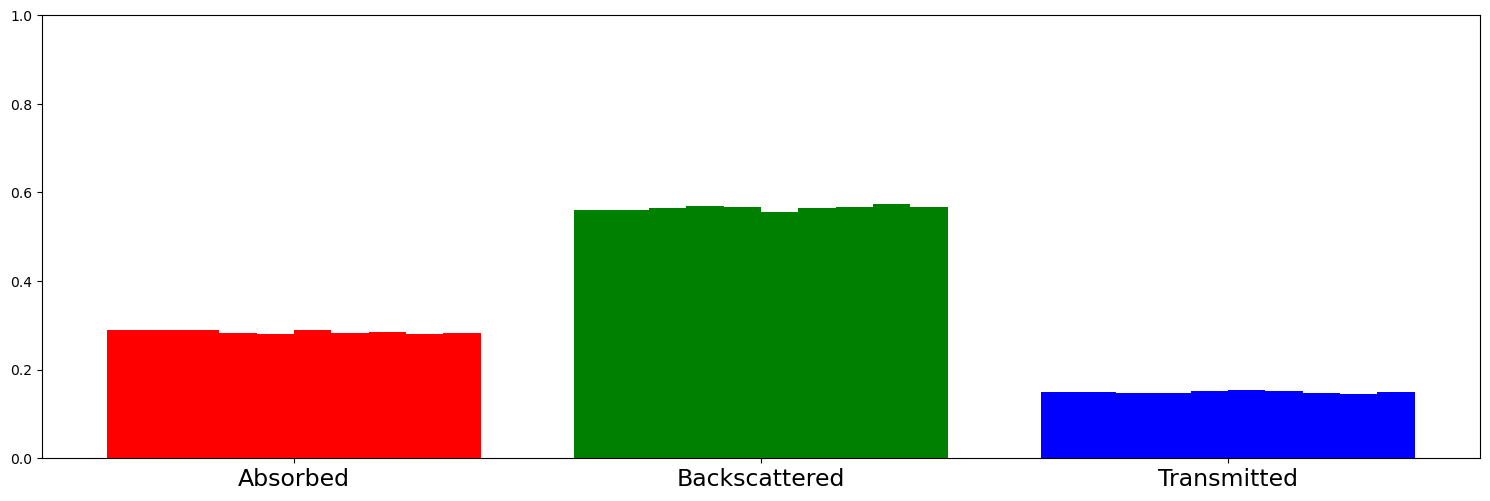

In [125]:
def Woodcock(sample_size: int, material_one: dict, material_two: dict, thickness_1: float, thickness_2: float):
    '''
    We are assuming that Sigma_1 < Sigma_2 --> lambda_1 > lambda_2!!!!!!!!!!

    Function which uses the Woodock method to correctly simulate neutrons travelling
    through a block composed of two material of 'thickness_1' and 'thickness_2'

    Returns the updated values for previous_position and
    current_position

    Parameters
    ----------
    sample_size: int
    material_one: dict
    material_two: dict
    thickness_1: float
    thickness_2: float
    Returns
    -------
    3 ints
    
    '''
    macroscopic_cross_sections1 = [material_one['macroscopic_absorption_area'], material_one['macroscopic_scatter_area']]
    macroscopic_cross_sections2 = [material_two['macroscopic_absorption_area'], material_two['macroscopic_scatter_area']]
    Sigma_1 = np.sum(macroscopic_cross_sections1)
    Sigma_2 = np.sum(macroscopic_cross_sections2)
    Sigma_T = np.max([Sigma_1, Sigma_2])

    neutron_array = np.zeros((sample_size, 3))
    neutron_array_previous_step = np.zeros((sample_size, 3))
    neutron_array[:, 0] = random_exponential(1 / Sigma_1, sample_size)
    neutrons_left = sample_size

    number_absorbed = 0
    number_backscattered = 0
    number_transmitted = 0

    probability_real_step = Sigma_1 / Sigma_T

    while len(neutron_array) > 0:
        #random number for real/fictitous step comparison
        v = np.random.uniform(0, 1, neutrons_left)
        #all neutrons in material 1 and fictitiously moving, based on Sigma_T = Sigma_2
        fictitious, prev_fictitious = fictitious_step(neutron_array[(v >= probability_real_step) & (neutron_array[:, 0] < thickness_1)],\
            neutron_array_previous_step[(v >= probability_real_step) & (neutron_array[:, 0] < thickness_1)], 1 / Sigma_T)
        #all neutrons in material 1 and taking a real step, based on Sigma_1
        real_material_1, prev_1, number_absorbed, number_backscattered, number_transmitted = real_step(neutron_array[(v < probability_real_step) & (neutron_array[:, 0] < thickness_1)],\
            1 / Sigma_1, macroscopic_cross_sections1, number_absorbed, number_backscattered, number_transmitted, thickness_2)
        #all neutrons in material 2 behaving normally
        real_material_2, prev_2, number_absorbed, number_backscattered, number_transmitted = real_step(neutron_array[neutron_array[:, 0] >= thickness_1],\
            1 / Sigma_2, macroscopic_cross_sections2, number_absorbed, number_backscattered, number_transmitted, thickness_2)
        #stacking all new particle arrays
        neutron_array = np.vstack((fictitious, real_material_1, real_material_2))
        neutron_array_previous_step = np.vstack((prev_fictitious, prev_1, prev_2))
        neutrons_left = len(neutron_array)
    return(number_absorbed, number_backscattered, number_transmitted)

particle_behaviour = np.zeros((0, 3))
for _ in range(ITERATIONS):
    particle_behaviour = np.vstack((particle_behaviour, Woodcock(15000, MATERIALS_DICT['water'], MATERIALS_DICT['water'], 0.05, 0.1)))
print_average_behaviour('water', average_behaviour(particle_behaviour), 0.1)
behaviour_barplot(particle_behaviour)

particle_behaviour = np.zeros((0, 3))
for _ in range(ITERATIONS):
    particle_behaviour = np.vstack((particle_behaviour, Woodcock(15000, MATERIALS_DICT['lead'], MATERIALS_DICT['water'], 0.05, 0.1)))
print_average_behaviour('water', average_behaviour(particle_behaviour), 0.1)
behaviour_barplot(particle_behaviour)


As one can see, for water against water of thickness 0.05m, the material behaves exactly the same as water with a thickness 0.1m. Moreover, (as long as $\Sigma_1 < \Sigma_2$), then the function will work for any combination of materials.

When the first material is lead rather than water, many more neutrons are transmitted through. This makes sense since as the overall block tends to just being one material, we expect it to behave more like that material. Here, the block is tending twoards the behaviour of lead with a thickness of 0.1m